# Bayesian Neural Networks

Bayesian Neural Networks (BNNs) offer a compelling solution to some of the limitations commonly encountered in traditional neural networks. One prominent challenge is overfitting, where the model learns to memorize the training data instead of generalizing well to unseen examples. Additionally, conventional neural networks typically provide deterministic predictions without any indication of uncertainty or variability in the predictions, lacking error bars or confidence intervals.

BNNs address these issues by treating the weights and biases of the neural network as probabilistic variables. Instead of learning a single set of parameters, BNNs learn a distribution over parameters, allowing them to capture uncertainty in the model. By representing uncertainty, BNNs can provide probabilistic predictions, offering not just a single answer but a distribution of possible outcomes. This capability is crucial for tasks where understanding the uncertainty in predictions is essential, such as in medical diagnosis or financial forecasting.

To train a BNN, one typically employs Bayesian inference techniques (e.g. MCMC) to sample from the posterior distribution over the model parameters. This sampling process allows the model to explore the space of possible parameter configurations and learn the uncertainty inherent in the data. For further details, I recommend the paper by [Laurent Valentin Jospin et al.](https://arxiv.org/pdf/2007.06823.pdf).

## Like an ensemble

You can think of BNNs as ensemble methods, where multiple models are trained independently, and their predictions are combined to improve performance. In the case of BNNs, the distribution over parameters effectively represents an ensemble of models with different architectures, allowing for robust predictions that account for model uncertainty. 

To illustrate the connection to ensemble methods, I want to highlight a paper by [Yarin Gal and Zoubin Ghahramani](https://arxiv.org/pdf/1506.02142.pdf). As discussed in the introductory course, dropout implies that you discard a subset of nodes at every step of the training loop, i.e. you would normally only use dropout for training, not for prediction. However, if you include dropout when performing predictions, you are effectively running different architectures for every prediction, as the prediction will only be performed by a random subset of the nodes in your network. You will hence get different answers for the *same* input every time you rerun your network, just as if you were sampling from a distribution. In their paper, Yarin Gal and Zoubin Ghahramani show that you can approximate a Gaussian process using dropout if you choose a suitable loss function.

The approach above is but one example. There are other ways in which we can construct a network that reliably infer distributions. We will dive into a concrete implementation of a Bayesian appraoch below.

## How to implement Bayesian Neural Networks in PyTorch

To implement Bayesian Neural Networks in PyTorch, you need to install the library [pyro](https://docs.pyro.ai/en/stable/contrib.bnn.html). To show you how you use pyro for this purpose, we draw on the tutorial by Phillip Lippe on [UvA DL Notebooks](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html), a Deep Learning course from the University of Amsterdam. Check the course on their [homepage](https://uvadlc.github.io/) if you are interested. Note that we are here not following the approach by Yarin Gal and Zoubin Ghahramani discussed above.

But first, let's run a simple example ourselves. As always, we start by importing and installing the libraries that we need.

In [1]:
import torch
try:
    import pyro
except:
    !pip install pyro-ppl
    import pyro
    
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from pyro.infer import MCMC, NUTS # Bayesian Inference algorithms
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive

To use our neural network for regression, we need a dataset. Let's make a simple, synthetic one along the lines in the notebook from UvA DL Notebooks.

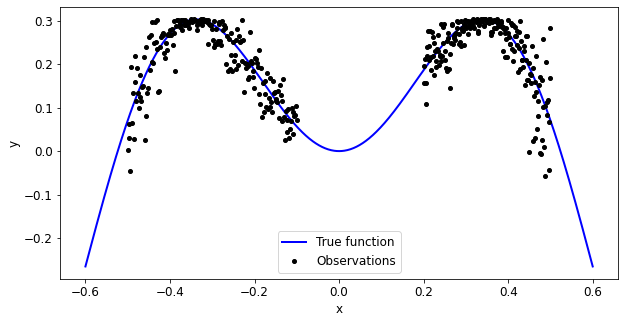

In [2]:
# Generate data
x_obs = np.hstack([np.linspace(-0.5, -0.1, 200), np.linspace(0.2, 0.5, 200)])
noise = 0.03 * np.random.randn(len(x_obs))
y_obs = (x_obs+noise)*np.sin(6*(x_obs + noise))

x_true = np.linspace(-0.6, 0.6, 1000)
y_true = np.sin(6*x_true)*x_true

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=2, label="True function")
ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observations")
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
plt.xticks(size=12)
plt.yticks(size=12)
ax.legend(loc="best", fontsize=12)
plt.show()

Let's now define our neural network architecture following the example given on UvA DL Notebooks.

In [3]:
class BayesianNN(PyroModule):
    def __init__(self, input_size=1, hidden_size1=5, hidden_size2=5, output_size=1,prior_scale=10.):
        super(BayesianNN, self).__init__()
        # Define layers
        self.fc1 = PyroModule[nn.Linear](input_size, hidden_size1)
        self.fc2 = PyroModule[nn.Linear](hidden_size1, hidden_size2)
        self.fc3 = PyroModule[nn.Linear](hidden_size2, output_size)

        # Set priors
        self.fc1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hidden_size1, input_size]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hidden_size1]).to_event(1))
        self.fc2.weight = PyroSample(dist.Normal(0., prior_scale).expand([hidden_size2, hidden_size1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., prior_scale).expand([hidden_size2]).to_event(1))
        self.fc3.weight = PyroSample(dist.Normal(0., prior_scale).expand([output_size, hidden_size2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., prior_scale).expand([output_size]).to_event(1))
        
    def forward(self, x, y=None):
        x = x.reshape(-1, 1) # Reshape input tensor
        # Put layers activation functions together
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mu = self.fc3(x).squeeze()
        # The output of your neural network is mu, i.e., the mean of y at that particular x.
        
        # But the data contains noise. So, we want to estimate the noise.
        # We sample it from Gamma distribution.
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise
        
        # Sampling model
        with pyro.plate("data", x.shape[0]):
            likelihood = pyro.sample("likelihood", dist.Normal(mu, sigma * sigma), obs=y)
            
        return mu

Let's pause here to take a closer look at what our network exactly does. In the method **\_\_init\_\_()**, we first define three fully connected layers. We do so using **PyroModule\[nn.Linear\]**, since this approach automatically registers the parameters as Pyro parameters so that they can be tracked during inference. Afterwards, the method contains several lines that define the priors of the different weights and biases. Remember from Bayesian statistics that we are thus interested in the posterior probability for our model parameters (M) given our observations (D) and prior knowledge I. We can compute the posterior probability using Bayes's law:

\begin{equation}
P(M|D,I) = \frac{P(D|M,I) \cdot P(M|I)}{P(D|I)}
\end{equation}

Where:
- $P(M|D,I)$ is the posterior probability of $M$ given $D$ and $I$.
- $P(D|M,I)$ is the likelihood of $D$ given $M$ and $I$.
- $P(M|I)$ is the prior probability of $M$.
- $P(D|I)$ is the marginal probability (evidence) of $D$.

In other words, we compute constraints on the model parameters using our priors on the model parameters and the likelihood of observing the collected data given the model and parameter values. Here, we use relatively broad normal priors, encouraging the parameters to stay close to zero unless the data suggests otherwise.

Let's now turn our attention to the method **forward()**. As always, forward defines our architecture, determining the order in which the features pass through the layers. What we aim for the network to predict is the mean value, **mu**, i.e., an approximation to the true function. However, the data also includes noise, and since we don't know the noise level a priori, we need to infer it: We sample **sigma**. We can then compute the likelihood by comparing the observations to **mu** under the assumption that the noise is Gaussian (normal). But wait... the method **forward()** only returns **mu**. We might compute sigma and sample to compare to data, but isn't this futile if we don't use it for anything? To answer this question, you need to know what happens behind the scenes: Pyro constructs a computation graph based on the operations performed within the forward method, representing the dependencies between variables in the model. It is this computation graph that the inference algorithm will draw on. 

Having defined the architecture, we can continue to call an instance of our network.

In [4]:
model = BayesianNN()

At this point, for the other neural networks we have seen, we would define a loss function and the optimisation algorithm. The logic is the same in the code below, but the concrete procedure is different. First, you have already defined the likelihood when you defined the network architecture. So, there is no need to define any loss function. Moreover, rather than using gradient descent or similar algorithms to optimise the network parameters, we will use Bayesian sampling algorithms, such as Hamiltonian Monte Carlo (HMC). More specifically, here we use [NUTS](https://arxiv.org/abs/1111.4246).

In [5]:
# Set Pyro random seed
pyro.set_rng_seed(42)

# Sampling algorihthm
nuts_kernel = NUTS(model, jit_compile=False)

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

Having defined the loss function and optimisation algorithm, we would normally proceed to training. Again, the logic is the same. However, here, we use a sampling algorithm that allows us to constrain the model parameters with a single line of code.

In [6]:
# Run MCMC
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [04:07,  2.47s/it, step size=1.68e-03, acc. prob=0.726]


That's it, really. We have now constrained the model parameters. Although... as always, it's not that simple. Once you have trained a neural network, you would need to check that the training results make sense. Normally, you would check that you are not overfitting, but overfitting is luckily not a thing in a Bayesian setting. On the contrary, you have to check that the chains have converged.

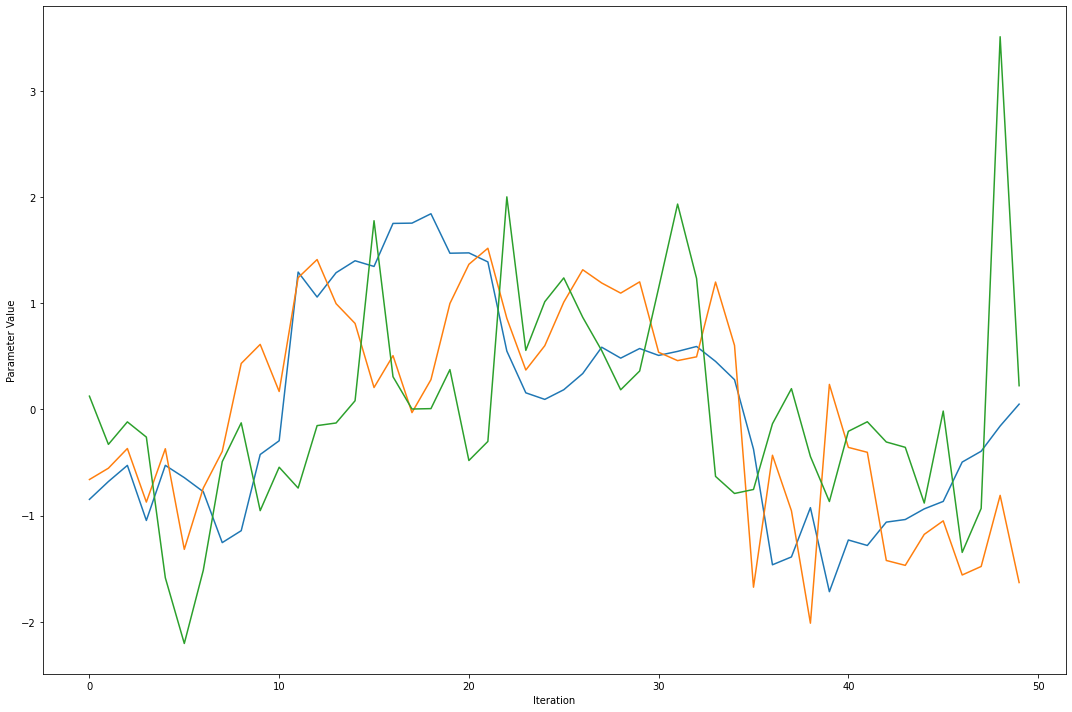

In [7]:
# Assuming you have already run MCMC and obtained the samples
samples = mcmc.get_samples()

# Get the list of parameter names
parameter_names = ["fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias"]

plt.figure(figsize=(15, 10))

# Plot trace plots for each parameter
for i, param_name in enumerate(parameter_names, start=1):
    if "weight" in param_name:
        samples_plot = samples[param_name][:, 0, 0].T
        plt.plot((samples_plot-samples_plot.mean())/samples_plot.std())
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')

plt.tight_layout()
plt.show()

What you expect to see is that the values from each iteration vary across a mean, i.e., they fluctuate but are constant, neither increasing nor decreasing. That might be the case here (or not if you rerun), but the lines don't vary so much as to ensure that you have truly mapped the full posterior distribution of the parameters. The solution to this is simple: **num_samples=50** was too low. We need more samples. Of course, you might point out that creating plots of this type seems rather cumbersome once you are dealing with more than a few parameters. We discuss this further in the exercises.

If you think that your training has converged to the true posterior, you can apply your network to your testing data.

In [8]:
from pyro.infer import Predictive

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(np.min(x_true), np.max(x_true), 3000)
preds = predictive(x_test)

## Exercises

**Exercise 1:** Plot the outcome of the final test. You can use the plotting function in the first example of the [UvA tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html). What does your plot tell you?

**Exercise 2:** Create your own data set with missing data and noise.

**Exercise 3:** Above, we define very broad Gaussian priors that encourage the use of low values for the weights and biases (this is the Bayesian pendant to regularisation). What happens to the performance if you comment on the priors? Why?

**Exercise 4:** Above, we only plot a single chain for the weights in the trace plots. Can you plot all the chains for a single weight? How does that look? What does that tell you? Can you plot the corresponding trace plots for the biases?

**Exercise 5:** Above, we check convergence using trace plots (we plot the parameter values as a function of the iteration). However, you can use metrics such as Gelman-Rubin Statistic (R-hat). What does this mean, and how would you implement it? Alternatively, or in tandem, you can use the so-called effective sample size or autocorrelation lengths. What are those, and how would you compute them in Python?

**Exercise 6:** Have a look at the solutions to the exercises in the [UvA tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html). Discuss the changes compared to the first example in the tutorial.

**Exercise 7:** Here, we use HMC. What is HMC? Why can we use that when dealing with a neural network (Hint: gradients).

**Exercise 8:** Above, we create a data set with Gaussian noise. Imagine instead that your data stems from a Bernoulli process (Binomial). How would you change the setup in this case?

If you would like to read up further on Bayesian statistics, I recommend the online course [Bayesian rethinking](https://www.youtube.com/watch?v=FdnMWdICdRs&list=PLDcUM9US4XdPz-KxHM4XHt7uUVGWWVSus) by Richard McElreath.